# Classification avec une couche



**On va apprendre à :**
- Implémenter une classification à 2 classes avec une seule couche cachée
- Utiliser un neurone avec une activation non linéaire (tanh)
- Calculer la cross entropy
- Implémenter la propagation backward et forward



In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.linear_model

In [2]:
def plot_decision_boundary(pred_func,X,Y):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=Y[:,0], cmap=plt.cm.Spectral,edgecolors='black')

In [3]:
def sigmoid(x):
    return(np.divide(1,1+np.exp(-x)))

In [4]:
def create_rosace(d,n,npoints,p):
    np.random.seed(42)
    t = np.random.rand(npoints)*2*3.1415
    t = np.sort(t)
    r = 0.05 * np.random.randn(npoints) + 1
    X = np.zeros((t.shape[0],2))
    X[:,0] = np.multiply(np.multiply(r,np.cos(t*n/d)),np.sin(t))
    X[:,1] = np.multiply(np.multiply(r,np.cos(t*n/d)),np.cos(t))
    Y = np.zeros((npoints,1))
    thresholds = np.arange(0,npoints,npoints//(n*4))
    noise = np.random.binomial(1, p, npoints)
    temp = 0
    classes = np.array([1,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1])
    for i,s in enumerate(thresholds[:-1]):
        Y[s:thresholds[i+1],0] = (classes[i]+noise[s:thresholds[i+1]])%2
    Y[thresholds[-1]:,0] = (classes[-1]+noise[s:thresholds[i+1]])%2
    return(X,Y)

La fonction ci-dessous va créer le data set contenant 400 points dans un plan. La rosace obtenue n'est pas linéairement séparable

In [6]:
X,Y = create_rosace(1,4,400,0.1)

Jetons un oeil sur le dataset, contenant deux classes : rouge (y=0) et bleu (y=1)

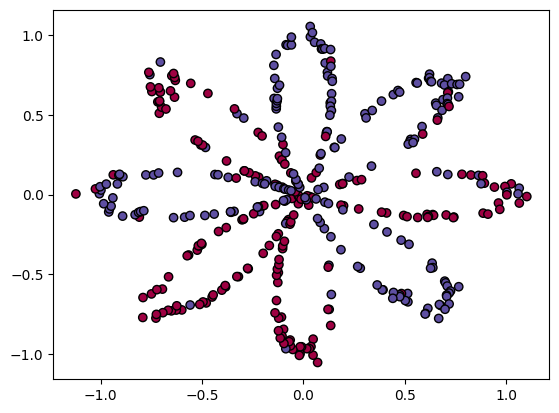

In [7]:
plt.scatter(X[:,0],X[:,1],c=Y[:,0],cmap=plt.cm.Spectral,edgecolors='black')

Vous avez:
    - une matrie X qui contient les coordonnées (x1, x2)
    - u vecteur Y qui contient les labels (red:0, blue:1).

On commence par jeter un oeil rapide sur la donnée.

**Exercice**: Combien d'exemple on a? Quelle est la dimension de `X` et `Y`? 

**Indication**: Dimension d'un array? [(help)](https://docs.scipy.org/doc/numpy/reference/generated/numpy.ndarray.shape.html)

In [13]:
### START CODE HERE ### (≈ 3 lines of code)

shape_X = X.shape 
shape_Y = Y.shape
m = X.shape[0]
### END CODE HERE ###

print ('The shape of X is: ' + str(shape_X))
print ('The shape of Y is: ' + str(shape_Y))
print ('I have m = %d training examples!' % (m))

The shape of X is: (400, 2)
The shape of Y is: (400, 1)
I have m = 400 training examples!


**Output**:
       
<table style="width:20%">
  
  <tr>
    <td>**shape of X**</td>
    <td> (2, 400) </td> 
  </tr>
  <tr>
    <td>**shape of Y**</td>
    <td>(1, 400) </td> 
  </tr>
      <tr>
    <td>**m**</td>
    <td> 400 </td> 
  </tr>
  
</table>

## 3 - Simple régression logistique

Avant de se lancer sur le réseau de neurones, voyons comment se débrouille la régression logistique

In [ ]:
# Train the logistic regression classifier
clf = sklearn.linear_model.LogisticRegressionCV();
clf.fit(X, Y);

In [ ]:
# Plot the decision boundary for logistic regression
plot_decision_boundary(lambda x: clf.predict(x),X,Y)
plt.title("Logistic Regression")

# Print accuracy
LR_predictions = clf.predict(X)
print ('Accuracy of logistic regression: %d ' % float((np.dot(Y.T,LR_predictions) + np.dot(1-Y.T,1-LR_predictions))/float(Y.T.size)*100) +
       '% ' + "(percentage of correctly labelled datapoints)")

**Output**:

<table style="width:20%">
  <tr>
    <td>**Accuracy**</td>
    <td> 55% </td> 
  </tr>
  
</table>



**Interpretation**: Le dataset n'est pas linéairement séparable,  la régression logistique a choisit une frontière de décision linéaire la plus acceptable

## 4 - Neural Network model

La régression logistique ne convient pas pour le data set, on va donc tester un réseau de neurones à une couche.

**Voici le modèle**:
<img src="images/classification_kiank.png" style="width:600px;height:300px;">

**On a donc les formules suivantes**:

Pour un exemple $x^{(i)}$:
$$z^{[1] (i)} =  W^{[1]} x^{(i)} + b^{[1] (i)}\tag{1}$$ 
$$a^{[1] (i)} = \tanh(z^{[1] (i)})\tag{2}$$
$$z^{[2] (i)} = W^{[2]} a^{[1] (i)} + b^{[2] (i)}\tag{3}$$
$$\hat{y}^{(i)} = a^{[2] (i)} = \sigma(z^{ [2] (i)})\tag{4}$$
$$y^{(i)}_{prediction} = \begin{cases} 1 & \mbox{if } a^{[2](i)} > 0.5 \\ 0 & \mbox{sinon } \end{cases}\tag{5}$$

Etant donné les prédictions faites sur tous les exemples, on peut alors calculer J :
$$J = - \frac{1}{m} \sum\limits_{i = 0}^{m} \large\left(\small y^{(i)}\log\left(a^{[2] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[2] (i)}\right)  \large  \right) \small \tag{6}$$

**Rappel**: La méthodologie générale pour construire un réseau de neurones est la suivante
    1. Définir l'architecture du réseau, ( # de l'input,  # couches, # units par couches, etc)
    2. Initialiser les paramètres du modèle
    3. Boucle sur le nombre d'itération :
        - Forward propagation
        - Calcule du coût
        - Backward propagation pour obtenir le gradient relatif à chaque paramètre
        - Mise à jour des paramètres

Généralement, on construit les fonctions pour faire les étapes 1 à 3 et ensuite on rassemble le tout dans une fonction `nn_model()`, par exemple.
Une fois `nn_model()`  construit et les paramètres appris, on peut faire la prédiction.

### 4.1 - Définition de l'architecture ####

**Exercicee**: Définir les variables:
    - n_x: taille de l' input layer
    - n_h: taille de la  couche cachée (set this to 4) 
    - n_y: taille de l'output

**Indication**: Utiliser les dimensions de X et Y pour définir n_x et n_y. 

In [ ]:
def layer_sizes(X, Y):
    """
    Arguments:
    X -- input dataset of shape (input size, number of examples)
    Y -- labels of shape (output size, number of examples)
    
    Returns:
    n_x -- the size of the input layer
    n_h -- the size of the hidden layer
    n_y -- the size of the output layer
    """
    ### START CODE HERE ### (≈ 3 lines of code)
    
    ### END CODE HERE ###
    return (n_x, n_h, n_y)

In [ ]:
(n_x, n_h, n_y) = layer_sizes(np.zeros((5,10)), np.zeros(2))
print("The size of the input layer is: n_x = " + str(n_x))
print("The size of the hidden layer is: n_h = " + str(n_h))
print("The size of the output layer is: n_y = " + str(n_y))

**Output**:

<table style="width:20%">
  <tr>
    <td>**n_x**</td>
    <td> 5 </td> 
  </tr>
    <tr>
    <td>**n_h**</td>
    <td> 4 </td> 
  </tr>
    <tr>
    <td>**n_y**</td>
    <td> 2 </td> 
  </tr>
  
</table>

### 4.2 - Initialisation des paramètres du modèle####

**Exercise**: Implémenter `initialize_parameters()`.

**Instructions**:
- S'assurer que les dimensions des paramètres sont corrects en se référant à la figure ci-dessous si besoin.
- La matrice des poids sera initialisée avec des valeurs aléatoires
    -  `np.random.randn(a,b) * 0.01
- Le bias est initialisé à un vecteur nul 
    - Use: `np.zeros((a,b))`

In [ ]:
def initialize_parameters(n_x, n_h, n_y):
    """
    Argument:
    n_x -- size of the input layer
    n_h -- size of the hidden layer
    n_y -- size of the output layer
    
    Returns:
    params -- python dictionary containing your parameters:
                    W1 -- weight matrix of shape (n_h, n_x)
                    b1 -- bias vector of shape (n_h, 1)
                    W2 -- weight matrix of shape (n_y, n_h)
                    b2 -- bias vector of shape (n_y, 1)
    """
    
    np.random.seed(2) # we set up a seed so that your output matches ours although the initialization is random.
    
    ### START CODE HERE ### (≈ 4 lines of code)

    ### END CODE HERE ###
    
    assert (W1.shape == (n_h, n_x))
    assert (b1.shape == (n_h, 1))
    assert (W2.shape == (n_y, n_h))
    assert (b2.shape == (n_y, 1))
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

In [ ]:
parameters = initialize_parameters(2, 4, 1)
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

**Expected Output**:

<table style="width:90%">
  <tr>
    <td>**W1**</td>
    <td> [[-0.00416758 -0.00056267]
 [-0.02136196  0.01640271]
 [-0.01793436 -0.00841747]
 [ 0.00502881 -0.01245288]] </td> 
  </tr>
  
  <tr>
    <td>**b1**</td>
    <td> [[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]] </td> 
  </tr>
  
  <tr>
    <td>**W2**</td>
    <td> [[-0.01057952 -0.00909008  0.00551454  0.02292208]]</td> 
  </tr>
  

  <tr>
    <td>**b2**</td>
    <td> [[ 0.]] </td> 
  </tr>
  
</table>




### 4.3 - La boucle d'apprentissage####

**Question**: Implémenter `forward_propagation()`.

**Instructions**:
- S'aider des formules ci-dessus 
- Utiliser la fonction `sigmoid()` implémentée au début du notebook
- S'aider de numpy pour `tanh()`
- Les étapes sont:
    1. Retrouver chaque paramètre dans le dictionnaire "parameters" (output de `initialize_parameters()`)
    2. Implémenter la Forward Propagation. Calculer $Z^{[1]}, A^{[1]}, Z^{[2]}$ and $A^{[2]}$ (contenant les prédictions de l'ensemble des examples).
- Les valeurs requises pour la backpropagation sont stockées dans `cache`. Le `cache` sera donné en input de la fonction de backpropagation.

In [ ]:
# GRADED FUNCTION: forward_propagation

def forward_propagation(X, parameters):
    """
    Argument:
    X -- input data of size (n_x, m)
    parameters -- python dictionary containing your parameters (output of initialization function)
    
    Returns:
    A2 -- The sigmoid output of the second activation
    cache -- a dictionary containing "Z1", "A1", "Z2" and "A2"
    """
    # Retrieve each parameter from the dictionary "parameters"
    ### START CODE HERE ### (≈ 4 lines of code)
 
    ### END CODE HERE ###
    
    # Implement Forward Propagation to calculate A2 (probabilities)
    ### START CODE HERE ### (≈ 4 lines of code)
 
    ### END CODE HERE ###
    assert(A2.shape == (1, X.shape[1]))
    
    cache = {"Z1": Z1,
             "A1": A1,
             "Z2": Z2,
             "A2": A2}
    
    return A2, cache

In [ ]:
np.random.seed(2)
A2, cache = forward_propagation(np.random.randn(2,10),initialize_parameters(2, 4, 1))

# Note: we use the mean here just to make sure that your output matches ours. 
print(np.mean(cache['Z1']) ,np.mean(cache['A1']),np.mean(cache['Z2']),np.mean(cache['A2']))

**Expected Output**:
<table style="width:50%">
  <tr>
    <td> 0.005798984461314502 0.005796610352404685 -0.000261742368547134 0.49993456441152634
  </tr>
</table>

Maintenant qu'on a calculé $A^{[2]}$, qui contient $a^{[2](i)}$ pour chaque exemplen on peut calculer la fonction coût :

$$J = - \frac{1}{m} \sum\limits_{i = 0}^{m} \large{(} \small y^{(i)}\log\left(a^{[2] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[2] (i)}\right) \large{)} \small\tag{13}$$

**Exercice**: Implémenter `compute_cost()` pour calculer $J$.

**Instructions**:
- Il ya plusieurs façons d'implémenter la cross-entropy. Comme indication, voici comment j'aurais codé
$- \sum\limits_{i=0}^{m}  y^{(i)}\log(a^{[2](i)})$:
```python
logprobs = np.multiply(np.log(A2),Y)
cost = - np.sum(logprobs)                # pas de boucle for!
```

(on peut aussi utiliser `np.multiply()` et ensuite `np.sum()` ou directement `np.dot()`).



In [ ]:
# GRADED FUNCTION: compute_cost

def compute_cost(A2, Y, parameters):
    """
    Computes the cross-entropy cost given in equation (13)
    
    Arguments:
    A2 -- The sigmoid output of the second activation, of shape (1, number of examples)
    Y -- "true" labels vector of shape (1, number of examples)
    parameters -- python dictionary containing your parameters W1, b1, W2 and b2
    
    Returns:
    cost -- cross-entropy cost given equation (13)
    """
    
    m = Y.shape[1] # number of example

    # Compute the cross-entropy cost
    ### START CODE HERE ### (≈ 2 lines of code)
    
    ### END CODE HERE ###
    
    cost = np.squeeze(cost)     # makes sure cost is the dimension we expect. 
                                # E.g., turns [[17]] into 17 
    assert(isinstance(cost, float))
    
    return cost

In [ ]:
# GRADED FUNCTION: backward_propagation

def backward_propagation(parameters, cache, X, Y):
    """
    Implement the backward propagation using the instructions above.
    
    Arguments:
    parameters -- python dictionary containing our parameters 
    cache -- a dictionary containing "Z1", "A1", "Z2" and "A2".
    X -- input data of shape (2, number of examples)
    Y -- "true" labels vector of shape (1, number of examples)
    
    Returns:
    grads -- python dictionary containing your gradients with respect to different parameters
    """
    m = X.shape[1]
    
    # First, retrieve W1 and W2 from the dictionary "parameters".
    ### START CODE HERE ### (≈ 2 lines of code)
    W1 = parameters['W1']
    W2 = parameters['W2']
    ### END CODE HERE ###
        
    # Retrieve also A1 and A2 from dictionary "cache".
    ### START CODE HERE ### (≈ 2 lines of code)
    A1 = cache['A1']
    A2 = cache['A2']
    ### END CODE HERE ###
    
    # Backward propagation: calculate dW1, db1, dW2, db2. 
    ### START CODE HERE ### (≈ 6 lines of code, corresponding to 6 equations on slide above)
    
    ### END CODE HERE ###
    
    grads = {"dW1": dW1,
             "db1": db1,
             "dW2": dW2,
             "db2": db2}
    
    return grads

**Question**: Implementer la fonction `backward_propagation()` en vous aidant des équations ci-dessous.



<img src="images/grad_summary.png" style="width:600px;height:300px;">

<!--
$\frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)} } = \frac{1}{m} (a^{[2](i)} - y^{(i)})$

$\frac{\partial \mathcal{J} }{ \partial W_2 } = \frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)} } a^{[1] (i) T} $

$\frac{\partial \mathcal{J} }{ \partial b_2 } = \sum_i{\frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)}}}$

$\frac{\partial \mathcal{J} }{ \partial z_{1}^{(i)} } =  W_2^T \frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)} } * ( 1 - a^{[1] (i) 2}) $

$\frac{\partial \mathcal{J} }{ \partial W_1 } = \frac{\partial \mathcal{J} }{ \partial z_{1}^{(i)} }  X^T $

$\frac{\partial \mathcal{J} _i }{ \partial b_1 } = \sum_i{\frac{\partial \mathcal{J} }{ \partial z_{1}^{(i)}}}$

- $*$ est la multiplication terme à terme.
- on utilise les notations suivantes:
    - dW1 = $\frac{\partial \mathcal{J} }{ \partial W_1 }$
    - db1 = $\frac{\partial \mathcal{J} }{ \partial b_1 }$
    - dW2 = $\frac{\partial \mathcal{J} }{ \partial W_2 }$
    - db2 = $\frac{\partial \mathcal{J} }{ \partial b_2 }$
    
!-->

- Tips:
    - Pour calculer dZ1 on doit calculer $g^{[1]'}(Z^{[1]})$. Comme $g^{[1]}(.)$ est tanh, si $a = g^{[1]}(z)$ alors $g^{[1]'}(z) = 1-a^2$. On peut calculer 
    $g^{[1]'}(Z^{[1]})$ en utilisant `(1 - np.power(A1, 2))`.

### 4.4 - Intégrer 4.1, 4.2 et 4.3 dans nn_model() ####

**Question**: Intégrer dans `nn_model()`.

**Instruction**: Le réseau de neurones doit utiliser les fonctions construites précédemment.

In [ ]:
# GRADED FUNCTION: update_parameters

def update_parameters(parameters, grads, learning_rate = 1.2):
    """
    Updates parameters using the gradient descent update rule given above
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients 
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
    """
    # Retrieve each parameter from the dictionary "parameters"
    ### START CODE HERE ### (≈ 4 lines of code)
    
    ### END CODE HERE ###
    
    # Retrieve each gradient from the dictionary "grads"
    ### START CODE HERE ### (≈ 4 lines of code)
   
    ## END CODE HERE ###
    
    # Update rule for each parameter
    ### START CODE HERE ### (≈ 4 lines of code)
    
    ### END CODE HERE ###
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

In [ ]:
def nn_model(X, Y, n_h, num_iterations = 10000, print_cost=False):
    """
    Arguments:
    X -- dataset of shape (2, number of examples)
    Y -- labels of shape (1, number of examples)
    n_h -- size of the hidden layer
    num_iterations -- Number of iterations in gradient descent loop
    print_cost -- if True, print the cost every 1000 iterations
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    np.random.seed(3)
    n_x = layer_sizes(X, Y)[0]
    n_y = layer_sizes(X, Y)[2]
    
    # Initialize parameters, then retrieve W1, b1, W2, b2. Inputs: "n_x, n_h, n_y". Outputs = "W1, b1, W2, b2, parameters".
    ### START CODE HERE ### (≈ 5 lines of code)
    
    ### END CODE HERE ###
    # Loop (gradient descent)

    for i in range(0, num_iterations):
         
        ### START CODE HERE ### (≈ 4 lines of code)
        # Forward propagation. Inputs: "X, parameters". Outputs: "A2, cache".
        
        
        # Cost function. Inputs: "A2, Y, parameters". Outputs: "cost".
        
 
        # Backpropagation. Inputs: "parameters, cache, X, Y". Outputs: "grads".
        
 
        # Gradient descent parameter update. Inputs: "parameters, grads". Outputs: "parameters".
        
        
        ### END CODE HERE ###
        
        # Print the cost every 1000 iterations
        if print_cost and i % 1000 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))

    return parameters

### 4.5 Predictions

**Question**: Utiliser le modèke appris pour construire predict().
Utiliser la forward propagation pour calculer la prédiction

**Rappel**: predictions = $y_{prediction} = \mathbb 1 \text{{activation > 0.5}} = \begin{cases}
      1 & \text{si}\ activation > 0.5 \\
      0 & \text{sinon}
    \end{cases}$  

Par exemple, si on veut définir les entrées d'un array X comme 0 ou 1 en fonction d'un seuil on peut utiliser: ```X_new = (X > seuil)```

In [ ]:
def predict(parameters, X):
    """
    Using the learned parameters, predicts a class for each example in X
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    X -- input data of size (n_x, m)
    
    Returns
    predictions -- vector of predictions of our model (red: 0 / blue: 1)
    """
    
    # Computes probabilities using forward propagation, and classifies to 0/1 using 0.5 as the threshold.
    ### START CODE HERE ### (≈ 2 lines of code)
    
    ### END CODE HERE ###
    
    return predictions

Voyons comment se comporte le modèle!

In [ ]:
# Build a model with a n_h-dimensional hidden layer
parameters = nn_model(X.T, Y.T, n_h = 4, num_iterations = 10000, print_cost=True)

# Plot the decision boundary
plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
plt.title("Decision Boundary for hidden layer size " + str(4))

**Expected Output**:

<table style="width:40%">
  <tr>
    <td>**Cost after iteration 9000**</td>
    <td> 0.412498 </td> 
  </tr>
  
</table>



In [ ]:
# Print accuracy
predictions = predict(parameters, X.T)
print ('Accuracy: %d' % float((np.dot(Y.T,predictions.T) + np.dot(1-Y.T,1-predictions.T))/float(Y.T.size)*100) + '%')

**Expected Output**: 

<table style="width:15%">
  <tr>
    <td>**Accuracy**</td>
    <td> 86% </td> 
  </tr>
</table>

L'accuracy est particulièrement élevée comparée à la régression logistique. Le modèle a pu apprendre le pattern de la rosace. En réalité, les réseaux de neurones sont capables d'apprendre les frontières de décisions avec des non-linéarités importantes (si tant est qu'on ait assez de données), à la différence de la régression logistique.

Essayons d'augmenter la taille de la couche.

In [ ]:
# ~2 minutes to run

plt.figure(figsize=(16, 32))
hidden_layer_sizes = [1, 2, 3, 4, 5, 20, 50]
for i, n_h in enumerate(hidden_layer_sizes):
    plt.subplot(5, 2, i+1)
    plt.title('Hidden Layer of size %d' % n_h)
    parameters = nn_model(X.T, Y.T, n_h, num_iterations = 5000)
    plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
    predictions = predict(parameters, X.T)
    accuracy = float((np.dot(Y.T,predictions.T) + np.dot(1-Y.T,1-predictions.T))/float(Y.T.size)*100)
    print ("Accuracy for {} hidden units: {} %".format(n_h, accuracy))

**Interprétation**:
- Plus le modèle possède de neurones dans la couche, les plus gros modèles peuvent même complétement surapprendre.
- La meilleure taille semble être autour de n_h=4. Les plus gros modèles tendent à chercher l'overfitting.

**Autres questions**:

Quelques questions optionnelles : 
- Que se passe t'il si on change tanh par un sigmoid ou une ReLu?
- Que se passe t'il lorsqu'on change le learning rate?